## IMPORT  LIBLARY

In [1]:
# Import library yang diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
from google.colab import files
import time
import shutil
from sklearn.model_selection import train_test_split

# Set seed untuk reproduktibilitas
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# ==================== #
# DATA UNDERSTANDING   #
# ==================== #

# Upload file ZIP dataset
uploaded = files.upload()
print("\nFile yang diupload:")
for filename in uploaded.keys():
    print(f"- {filename}")

# Ekstrak ZIP jika ada
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"\nMengekstrak file {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/')
        print("Ekstraksi selesai!")

Saving dataset.zip to dataset.zip

File yang diupload:
- dataset.zip

Mengekstrak file dataset.zip...
Ekstraksi selesai!


In [3]:
# Cari path dataset
dataset_path = None
search_path = '/content'
for root, dirs, files in os.walk(search_path):
    if 'Animals' in dirs:
        dataset_path = os.path.join(root, 'Animals')
        break

if dataset_path is None:
    # Coba alternatif penamaan
    for root, dirs, files in os.walk(search_path):
        if 'animals' in dirs:
            dataset_path = os.path.join(root, 'animals')
            break
        elif 'animal' in dirs:
            dataset_path = os.path.join(root, 'animal')
            break

if dataset_path is None:
    raise FileNotFoundError("Direktori dataset tidak ditemukan. Pastikan file ZIP berisi folder 'Animals'")

# Path dataset
base_dir = dataset_path
print("\nIsi direktori dataset:")
print(os.listdir(base_dir))

# Dapatkan daftar kelas (cats, dogs, snakes)
classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
print("\nKelas hewan yang ditemukan:", classes)


Isi direktori dataset:
['snakes', 'cats', 'dogs']

Kelas hewan yang ditemukan: ['cats', 'dogs', 'snakes']


In [4]:
# Buat direktori train, validation, test
train_dir = os.path.join('/content', 'train')
val_dir = os.path.join('/content', 'validation')
test_dir = os.path.join('/content', 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Rasio pembagian
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

print("\nMembagi dataset menjadi train, validation, dan test...")
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Bagi dataset
    train_val, test = train_test_split(images, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)


    # Buat direktori kelas di train, val, test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Salin gambar
    for img in train:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy(src, dst)

    for img in val:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy(src, dst)

    for img in test:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy(src, dst)

    print(f"Kelas {class_name}: {len(train)} train, {len(val)} val, {len(test)} test")


Membagi dataset menjadi train, validation, dan test...
Kelas cats: 700 train, 150 val, 150 test
Kelas dogs: 700 train, 150 val, 150 test
Kelas snakes: 700 train, 150 val, 150 test


In [5]:
# Verifikasi path
print("\nStruktur Dataset:")
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Eksplorasi dataset
print("\nKelas Hewan:", classes)


Struktur Dataset:
Train directory: /content/train
Validation directory: /content/validation
Test directory: /content/test

Kelas Hewan: ['cats', 'dogs', 'snakes']


In [6]:
# Hitung jumlah gambar per kelas
def count_images(directory):
    counts = {}
    for animal in classes:
        animal_dir = os.path.join(directory, animal)
        if os.path.exists(animal_dir):
            counts[animal] = len(os.listdir(animal_dir))
        else:
            counts[animal] = 0
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("\nDistribusi Data:")
print("Kelas\t\tTrain\tValidation\tTest")
print("-" * 40)
for animal in classes:
    print(f"{animal.ljust(15)}\t{train_counts[animal]}\t{val_counts[animal]}\t\t{test_counts[animal]}")


Distribusi Data:
Kelas		Train	Validation	Test
----------------------------------------
cats           	700	150		150
dogs           	700	150		150
snakes         	700	150		150


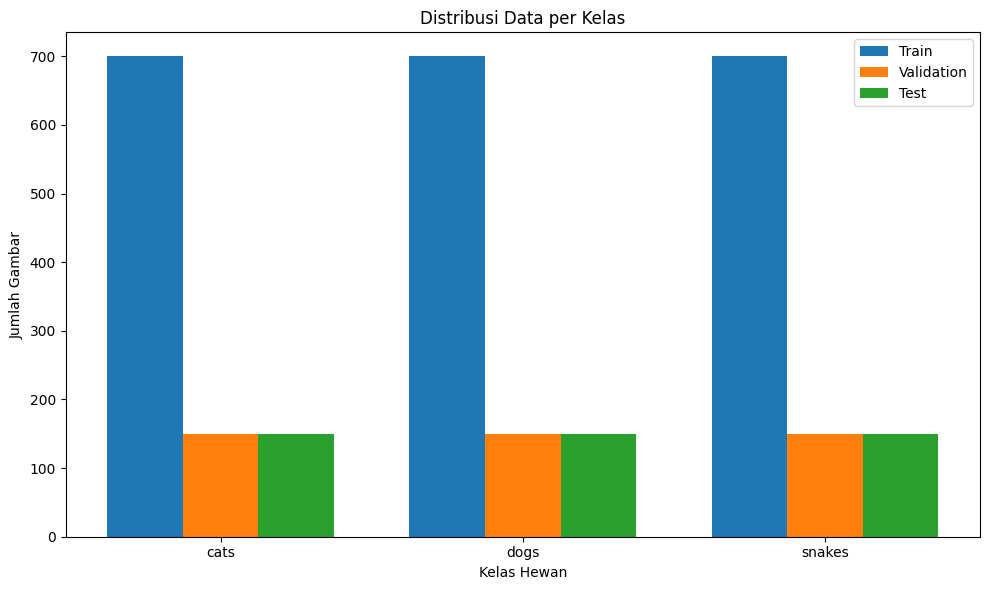

In [7]:
# Visualisasi distribusi data
plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, train_counts.values(), width, label='Train')
plt.bar(x, val_counts.values(), width, label='Validation')
plt.bar(x + width, test_counts.values(), width, label='Test')

plt.xlabel('Kelas Hewan')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Data per Kelas')
plt.xticks(x, classes)
plt.legend()
plt.tight_layout()
plt.show()

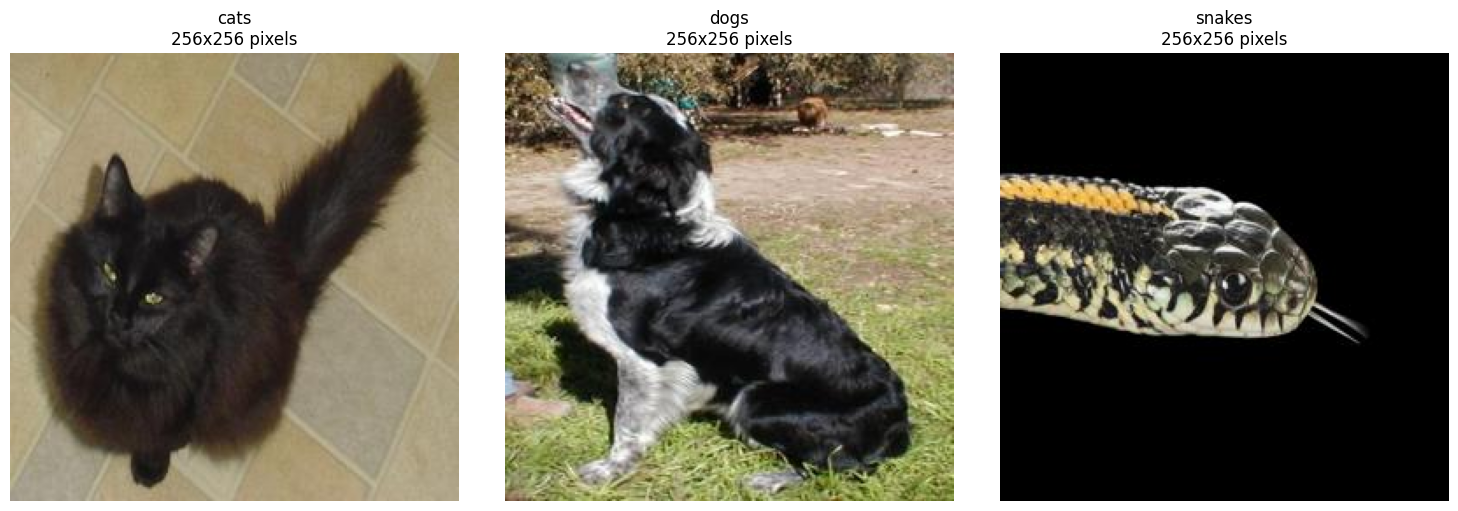

In [8]:
# Visualisasi sampel gambar
plt.figure(figsize=(15, 5))
for i, animal in enumerate(classes):
    animal_dir = os.path.join(train_dir, animal)
    img_files = os.listdir(animal_dir)

    # Pastikan ada file gambar di direktori
    if img_files:
        img_path = os.path.join(animal_dir, img_files[0])

        plt.subplot(1, 3, i+1)  # 1 baris, 3 kolom untuk 3 kelas
        try:
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.title(f"{animal}\n{img.shape[0]}x{img.shape[1]} pixels")
            plt.axis('off')
        except Exception as e:
            print(f"Tidak dapat membaca gambar {img_path}: {str(e)}")
            plt.title(f"{animal}\nGambar tidak tersedia")
            plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# ==================== #
# DATA PREPARATION     #
# ==================== #

# Konfigurasi gambar
img_size = (224, 224)
batch_size = 32

# Augmentasi data untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan test (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data
print("\nMempersiapkan data generator...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verifikasi jumlah kelas
num_classes = len(classes)
print(f"\nJumlah kelas yang terdeteksi: {num_classes}")


Mempersiapkan data generator...
Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.

Jumlah kelas yang terdeteksi: 3


In [10]:
# ==================== #
# MODELING             #
# ==================== #

# Fungsi untuk membuat model CNN sederhana
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Fungsi untuk membuat model berbasis ResNet50
def create_resnet_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )
    base_model.trainable = False  # Freeze weights

    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Fungsi untuk membuat model berbasis EfficientNetB0
def create_efficientnet_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )
    base_model.trainable = False  # Freeze weights

    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Inisialisasi model
models = {
    "Custom CNN": create_cnn_model(),
    "ResNet50": create_resnet_model(),
    "EfficientNetB0": create_efficientnet_model()
}

# Callback untuk early stopping dan learning rate reduction
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# ==================== #
# TRAINING             #
# ==================== #

print("\nMemulai pelatihan model...")
histories = {}
training_times = {}
epoch_counts = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training model {name}")
    print(f"{'='*50}")

    model.summary()

    start_time = time.time()

    # Konfigurasi epoch
    epochs = 25

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time
    training_times[name] = training_time
    histories[name] = history
    epoch_counts[name] = len(history.history['loss'])

    print(f"\nTraining {name} selesai!")
    print(f"Waktu training: {training_time/60:.2f} menit")
    print(f"Jumlah epoch: {epoch_counts[name]}")



Memulai pelatihan model...

Training model Custom CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,139 (99.99 MB)

 Trainable params: 26,211,139 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 494ms/step - accuracy: 0.3868 - loss: 1.1743 - val_accuracy: 0.5889 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.5574 - loss: 0.8854 - val_accuracy: 0.6133 - val_loss: 0.8547 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.5987 - loss: 0.7867 - val_accuracy: 0.6244 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step - accuracy: 0.5947 - loss: 0.7868 - val_accuracy: 0.6289 - val_loss: 0.7852 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.6316 - loss: 0.7706 - val_accuracy: 0.6178 - val_loss: 0.9088 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 382ms/step - accuracy: 0.6460 - loss: 0.7268 - val_accuracy: 0.6889 - val_loss: 0.6782 - learning_rate: 0.0010
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.6729 - loss: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,539 (92.11 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.3199 - loss: 1.2264 - val_accuracy: 0.5067 - val_loss: 1.0563 - learning_rate: 1.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.3640 - loss: 1.1353 - val_accuracy: 0.5000 - val_loss: 1.0323 - learning_rate: 1.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.3768 - loss: 1.1032 - val_accuracy: 0.5244 - val_loss: 0.9996 - learning_rate: 1.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.4472 - loss: 1.0554 - val_accuracy: 0.5422 - val_loss: 0.9661 - learning_rate: 1.0000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.4448 - loss: 1.0350 - val_accuracy: 0.5444 - val_loss: 0.9361 - learning_rate: 1.0000e-04
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.4702 - loss: 1.0113 - val_accuracy: 0.5422 - val_loss: 0.9345 - learning_rate: 1.0000e-04
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - acc

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,790 (16.83 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 691ms/step - accuracy: 0.3447 - loss: 1.1101 - val_accuracy: 0.3333 - val_loss: 1.1007 - learning_rate: 1.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 374ms/step - accuracy: 0.3346 - loss: 1.1015 - val_accuracy: 0.4289 - val_loss: 1.0982 - learning_rate: 1.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 374ms/step - accuracy: 0.3359 - loss: 1.1023 - val_accuracy: 0.3333 - val_loss: 1.0982 - learning_rate: 1.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 371ms/step - accuracy: 0.3079 - loss: 1.1058 - val_accuracy: 0.3333 - val_loss: 1.0983 - learning_rate: 1.0000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.3391 - loss: 1.0996
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.3390 - loss: 1.0996 - val_accuracy: 0.3333 - val_loss: 1.1002 - learning_rate: 1.0000e-04
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy


Evaluasi model Custom CNN


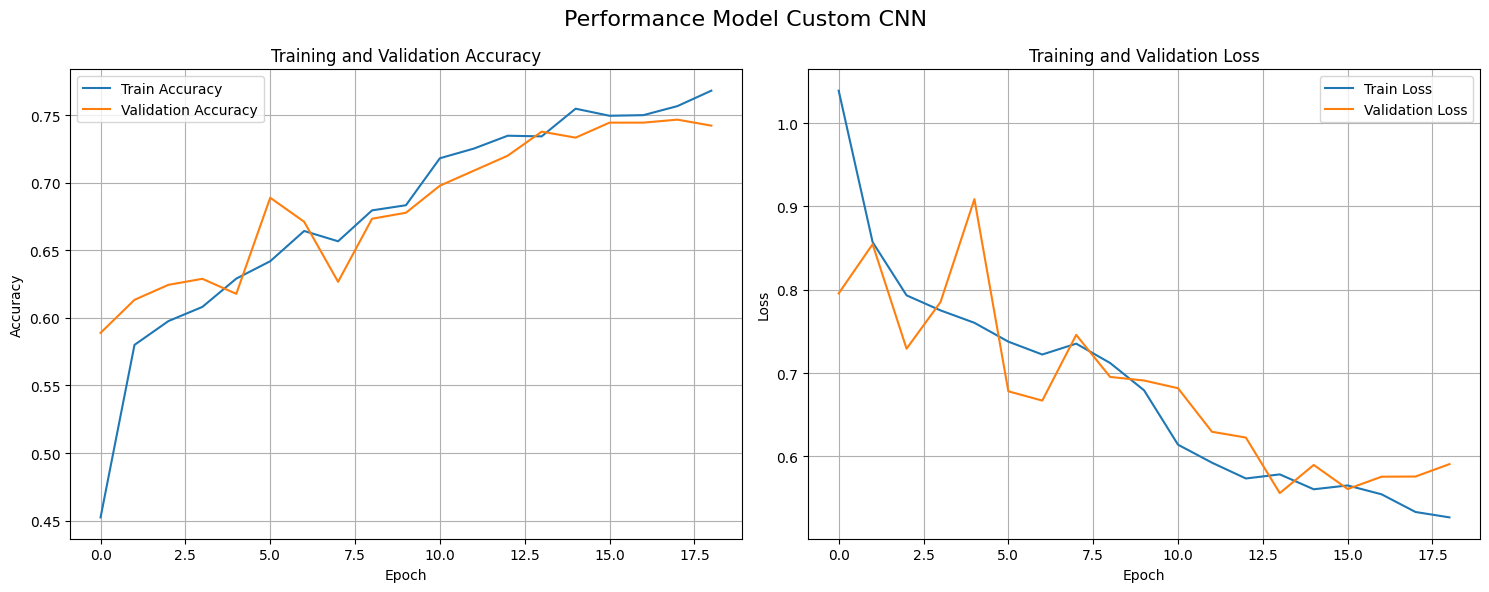


Test Accuracy: 0.7400
Test Loss: 0.5619

Classification Report:
              precision    recall  f1-score   support

        cats       0.66      0.71      0.68       150
        dogs       0.73      0.62      0.67       150
      snakes       0.83      0.89      0.86       150

    accuracy                           0.74       450
   macro avg       0.74      0.74      0.74       450
weighted avg       0.74      0.74      0.74       450



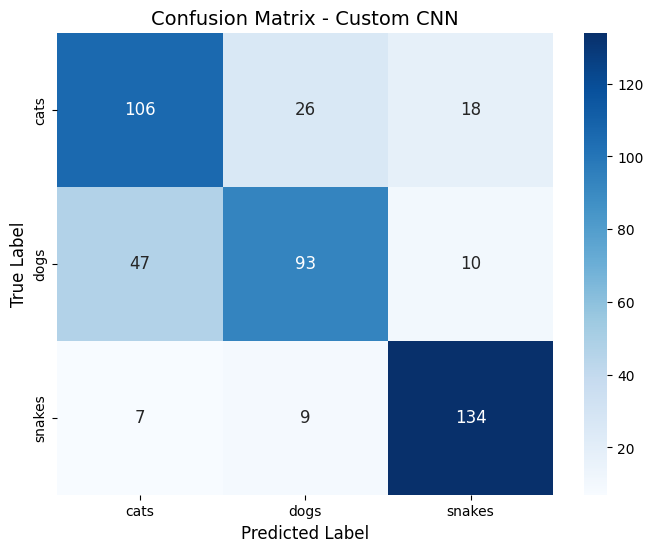


Evaluasi model ResNet50


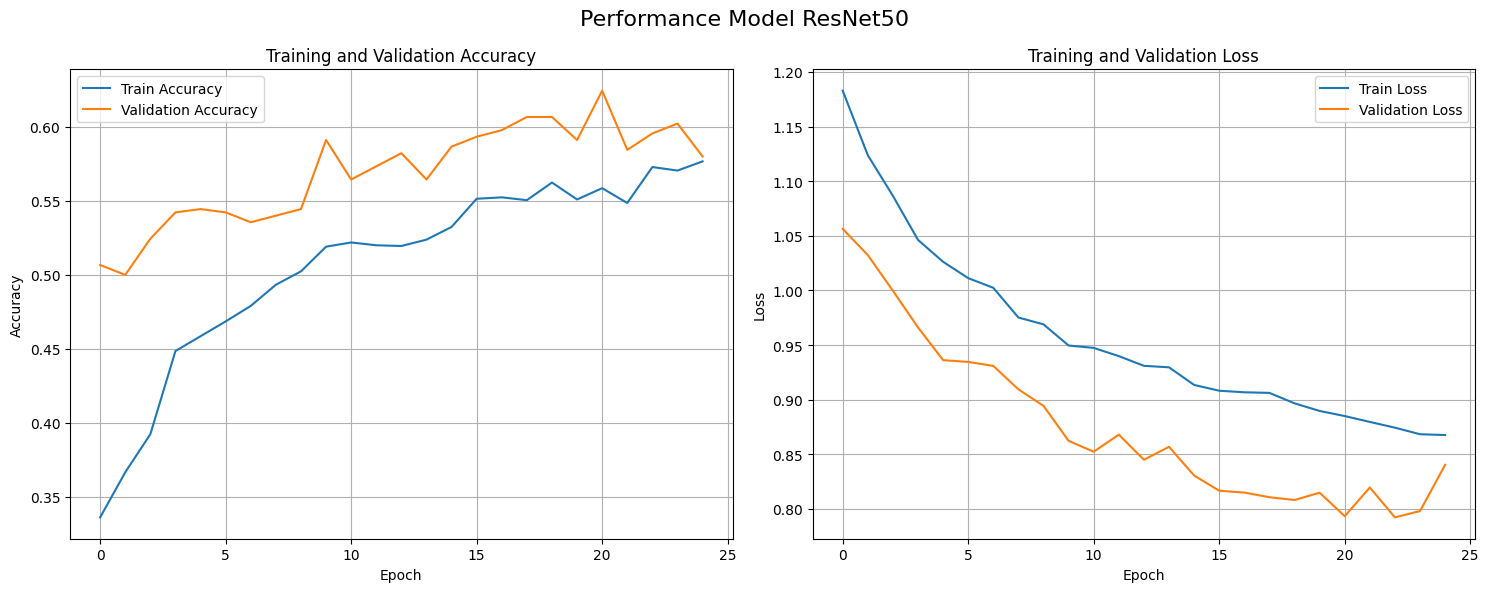


Test Accuracy: 0.6533
Test Loss: 0.7901

Classification Report:
              precision    recall  f1-score   support

        cats       0.63      0.63      0.63       150
        dogs       0.57      0.53      0.55       150
      snakes       0.74      0.80      0.77       150

    accuracy                           0.65       450
   macro avg       0.65      0.65      0.65       450
weighted avg       0.65      0.65      0.65       450



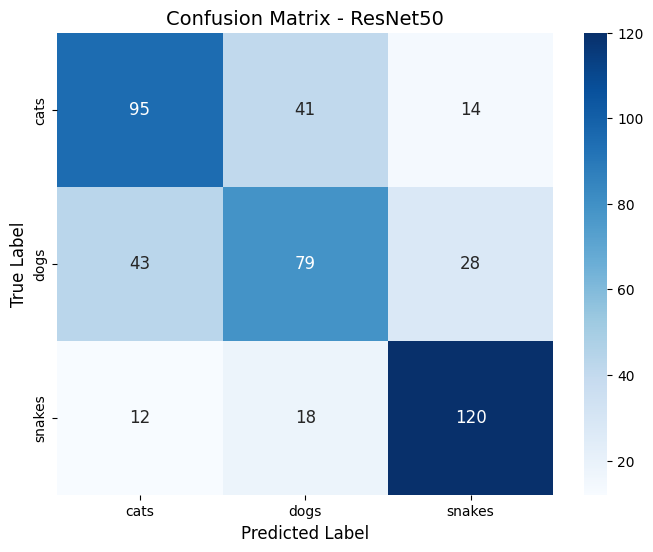


Evaluasi model EfficientNetB0


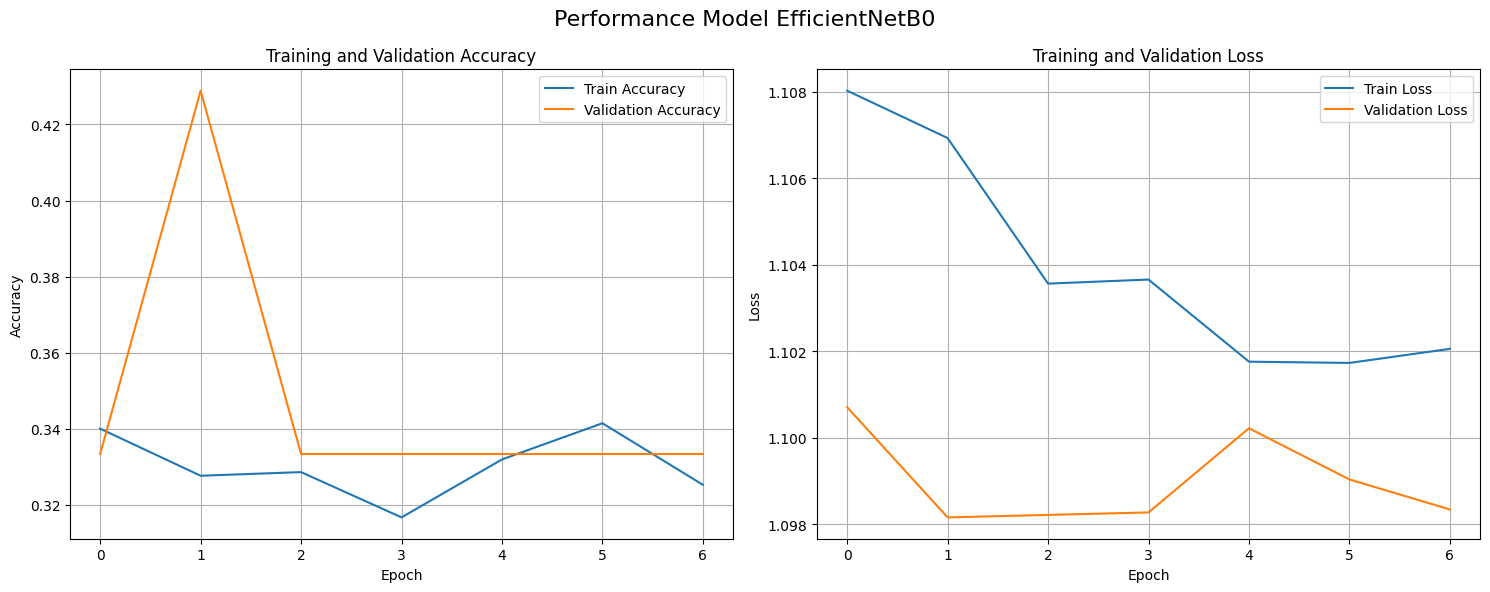


Test Accuracy: 0.4178
Test Loss: 1.0982

Classification Report:
              precision    recall  f1-score   support

        cats       0.37      0.99      0.53       150
        dogs       0.00      0.00      0.00       150
      snakes       0.89      0.27      0.41       150

    accuracy                           0.42       450
   macro avg       0.42      0.42      0.31       450
weighted avg       0.42      0.42      0.31       450



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


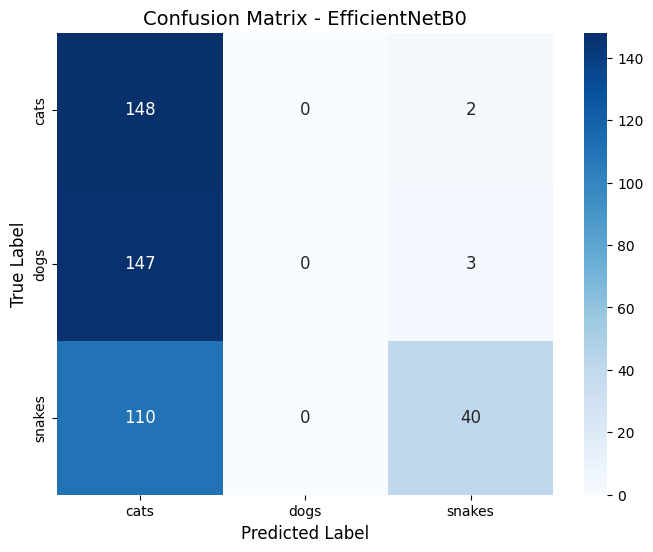

In [12]:
# ==================== #
# EVALUATION           #
# ==================== #

def evaluate_model(name, model, history, test_generator):
    print(f"\n{'='*50}")
    print(f"Evaluasi model {name}")
    print(f"{'='*50}")

    # Plot akurasi dan loss
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'Performance Model {name}', fontsize=16)

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluasi pada test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification report
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 12})
    plt.title(f'Confusion Matrix - {name}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    return test_acc

# Evaluasi semua model
results = {}
for name in models:
    test_acc = evaluate_model(name, models[name], histories[name], test_generator)
    results[name] = {
        'accuracy': test_acc,
        'training_time': training_times[name],
        'epochs': epoch_counts[name]
    }


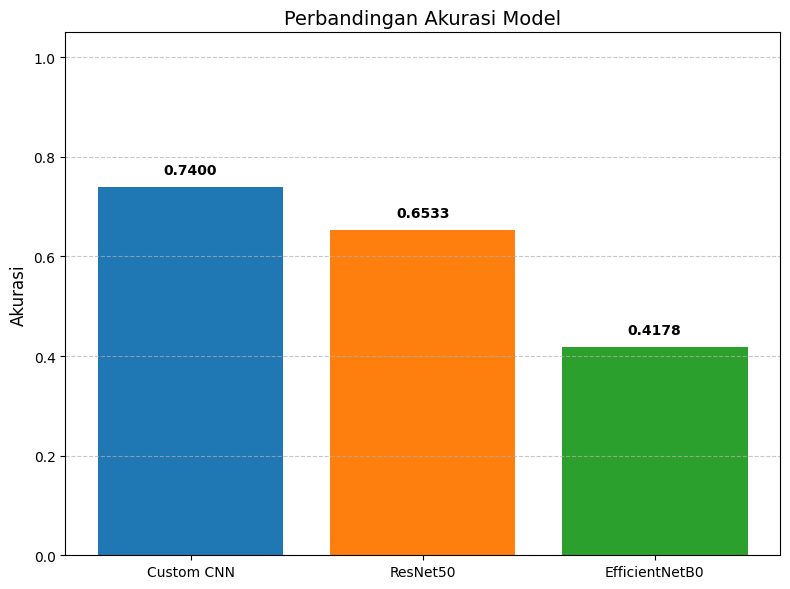

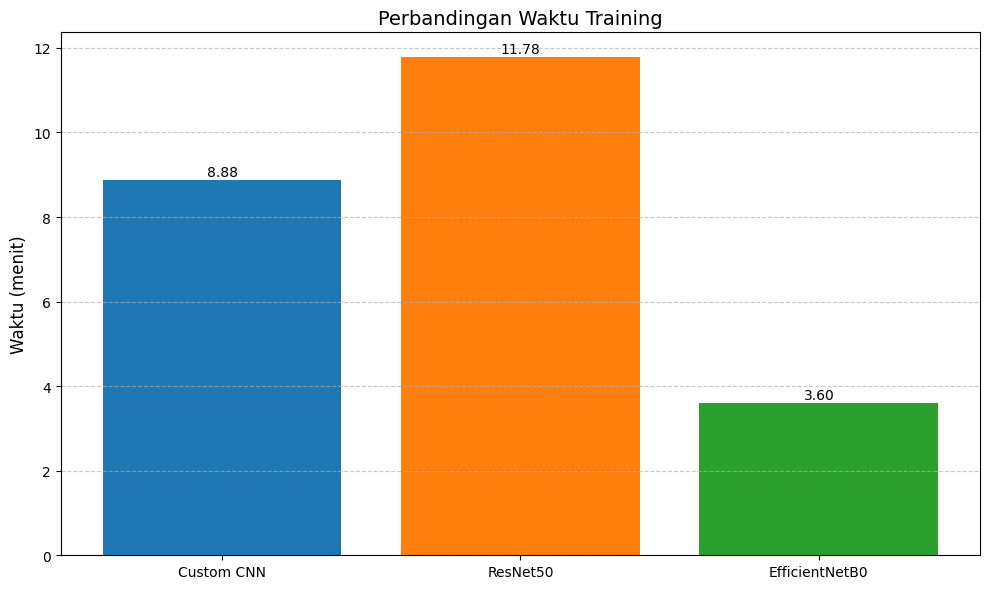


Proyek selesai dijalankan!


In [16]:
import matplotlib.pyplot as plt

# Data dari hasil model Anda
model_names = list(results.keys())
acc_values = [res['accuracy'] for res in results.values()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Ukuran figure diperbaiki agar tidak gepeng
plt.figure(figsize=(8, 6))

# Bar chart
bars = plt.bar(model_names, acc_values, color=colors)
plt.title('Perbandingan Akurasi Model', fontsize=14)
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0.0, 1.05)  # agar semua nilai muat dengan baik
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


# Visualisasi waktu training
plt.figure(figsize=(10, 6))
time_values = [res['training_time']/60 for res in results.values()]

plt.bar(model_names, time_values, color=colors)
plt.title('Perbandingan Waktu Training', fontsize=14)
plt.ylabel('Waktu (menit)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan nilai di atas bar
for i, v in enumerate(time_values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nProyek selesai dijalankan!")